In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [16]:
df = pd.read_csv('../Dataset/HPG.csv')
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")
df.set_index("date", inplace=True)
series = df["close"]
""

''

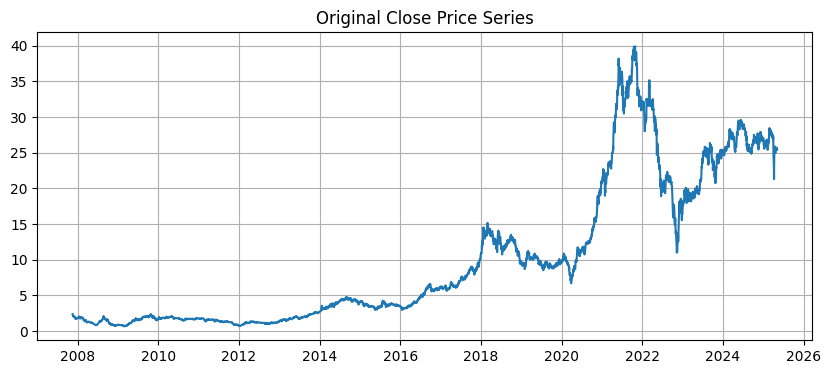

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(series)
plt.title("Original Close Price Series")
plt.grid(True)
plt.show()

In [18]:
adf_result = adfuller(series)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

ADF Statistic: -0.8820268518048768
p-value: 0.7938335996205055
Critical Values: {'1%': np.float64(-3.431864627292699), '5%': np.float64(-2.8622092782958526), '10%': np.float64(-2.567126261627658)}



After 1st differencing:
ADF Statistic: -10.688740670012335
p-value: 3.773664488071385e-19
Critical Values: {'1%': np.float64(-3.4318649781908066), '5%': np.float64(-2.862209433310026), '10%': np.float64(-2.567126344149579)}


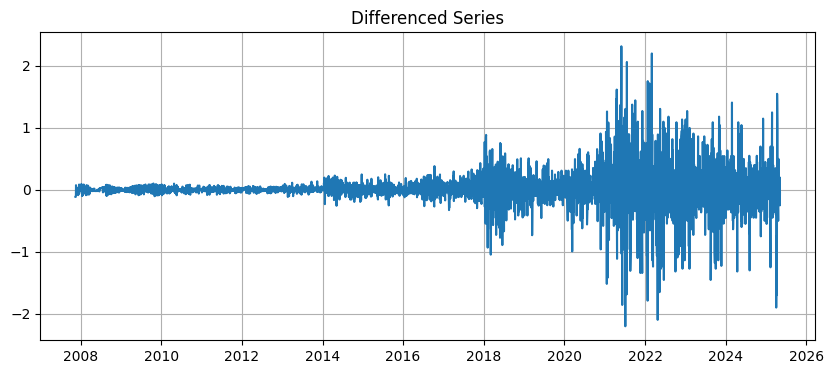

In [19]:
d = 0
if adf_result[1] > 0.05:
    d = 1
    series_diff = series.diff().dropna()
    adf_diff_result = adfuller(series_diff)
    print("\nAfter 1st differencing:")
    print("ADF Statistic:", adf_diff_result[0])
    print("p-value:", adf_diff_result[1])
    print("Critical Values:", adf_diff_result[4])

    # Plot differenced series
    plt.figure(figsize=(10, 4))
    plt.plot(series_diff)
    plt.title("Differenced Series")
    plt.grid(True)
    plt.show()
else:
    series_diff = series

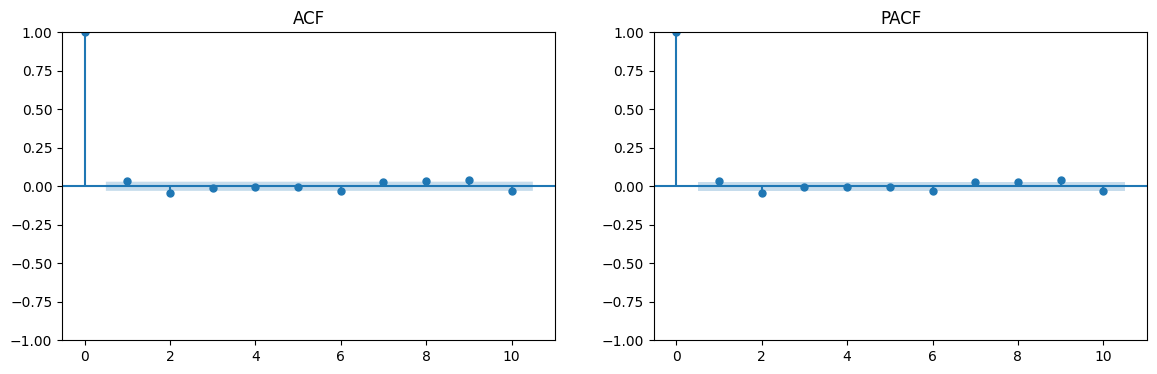

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(series_diff, ax=axes[0], lags=10)
plot_pacf(series_diff, ax=axes[1], lags=10)
axes[0].set_title("ACF")
axes[1].set_title("PACF")
plt.show()

In [21]:
best_aic = float("inf")
best_bic = float("inf")
best_avg = float("inf")
best_order = None
results_table = []

for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(series, order=(p, d, q)).fit()
            aic = model.aic
            bic = model.bic
            avg = (aic+bic)/2
            results_table.append((p, d, q, aic, bic))
            if avg < best_avg:
                best_aic = aic
                best_bic = bic
                best_avg = avg
                best_order = (p, d, q)
        except:
            continue



In [22]:
results_df = pd.DataFrame(results_table, columns=["p", "d", "q", "AIC", "BIC"])
print("\nAll tried models:")
print(results_df.sort_values("AIC"))

print(f"\n✅ Best model: ARIMA{best_order} with AIC={best_aic:.2f}, BIC={best_bic:.2f}")


All tried models:
    p  d  q          AIC          BIC
15  3  1  3  1624.750190  1669.397317
5   1  1  1  1624.969904  1644.104387
7   1  1  3  1625.646737  1657.537542
11  2  1  3  1626.348498  1664.617464
8   2  1  0  1627.905882  1647.040365
2   0  1  2  1628.090163  1647.224646
6   1  1  2  1629.574961  1655.087605
3   0  1  3  1629.631135  1655.143779
9   2  1  1  1629.638310  1655.150954
12  3  1  0  1629.674922  1655.187566
10  2  1  2  1631.576170  1663.466975
13  3  1  1  1631.678576  1663.569381
1   0  1  1  1633.051084  1645.807406
14  3  1  2  1633.520921  1671.789887
4   1  1  0  1633.575712  1646.332034
0   0  1  0  1637.463576  1643.841737

✅ Best model: ARIMA(1, 1, 1) with AIC=1624.97, BIC=1644.10


In [25]:
forecast_results = {}
forecast_steps = [1, 30, 60]
for forecast_step in forecast_steps:
    train = series[:-forecast_step]
    test = series[-forecast_step:]
    best_model = ARIMA(train, order=best_order).fit()
    forecast = best_model.forecast(steps=forecast_step)
    future_dates = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_step, freq='B')
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)

    forecast_results[forecast_step] = {
        'mae': mae,
        'mse': mse,
        'test': test,
        'forecast': forecast
    }
    print(f"MAE({forecast_step} steps) : {mae}")
    print(f"MSE({forecast_step} steps): {mse}")

MAE(1 steps) : 0.04121884069639492
MSE(1 steps): 0.0016989928283547822
MAE(30 steps) : 1.6041231052894582
MSE(30 steps): 4.404396574056933
MAE(60 steps) : 1.1391465847073172
MSE(60 steps): 2.1663462454682594


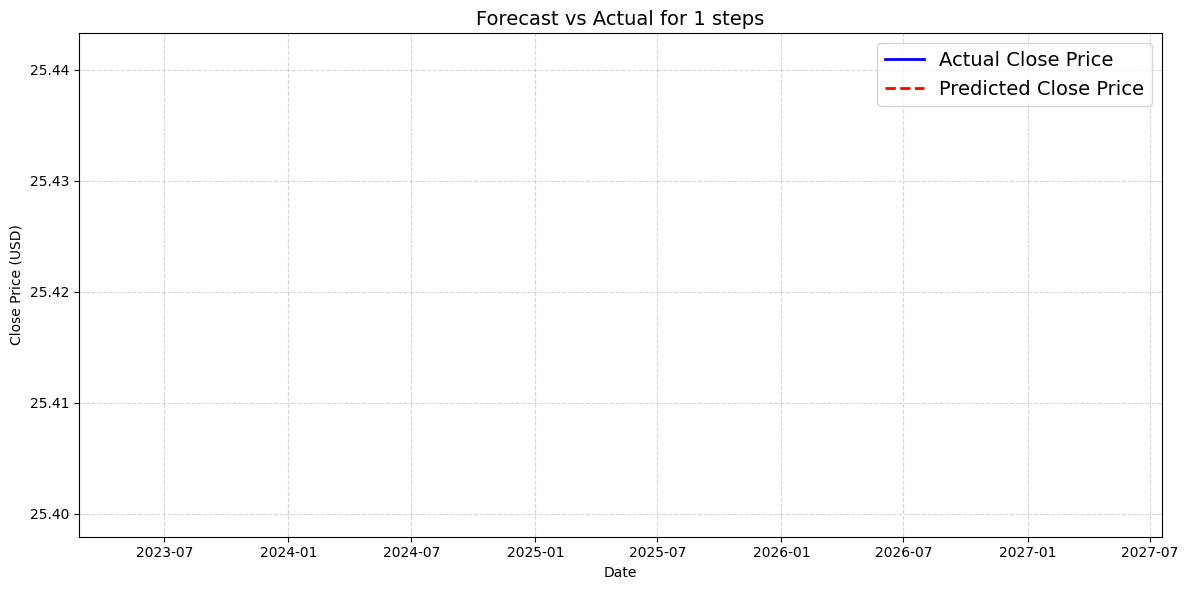

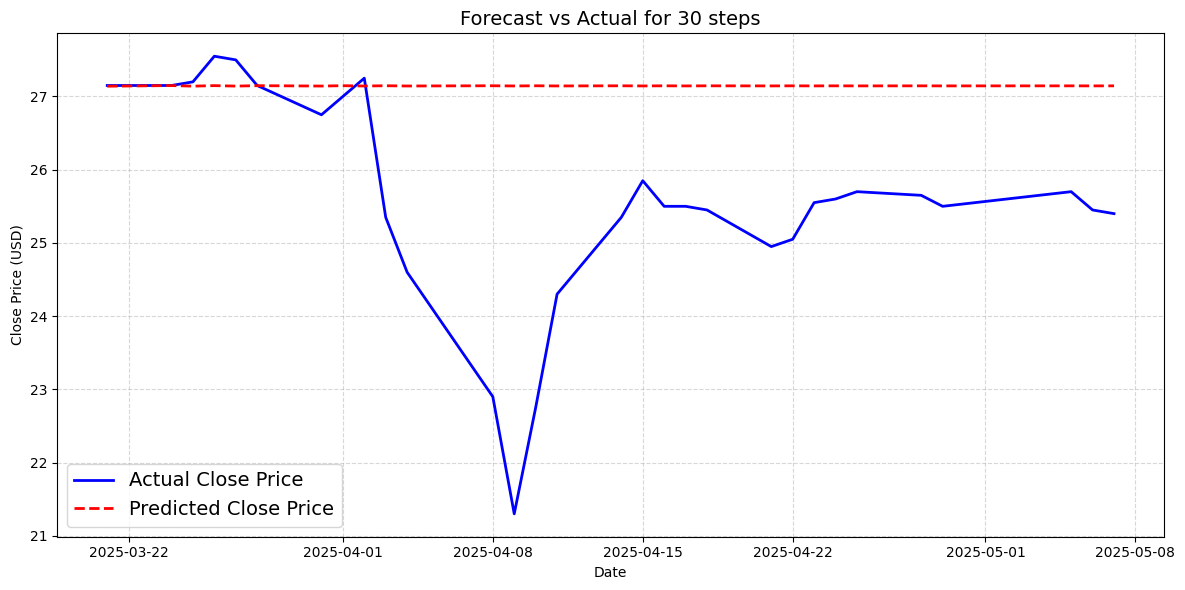

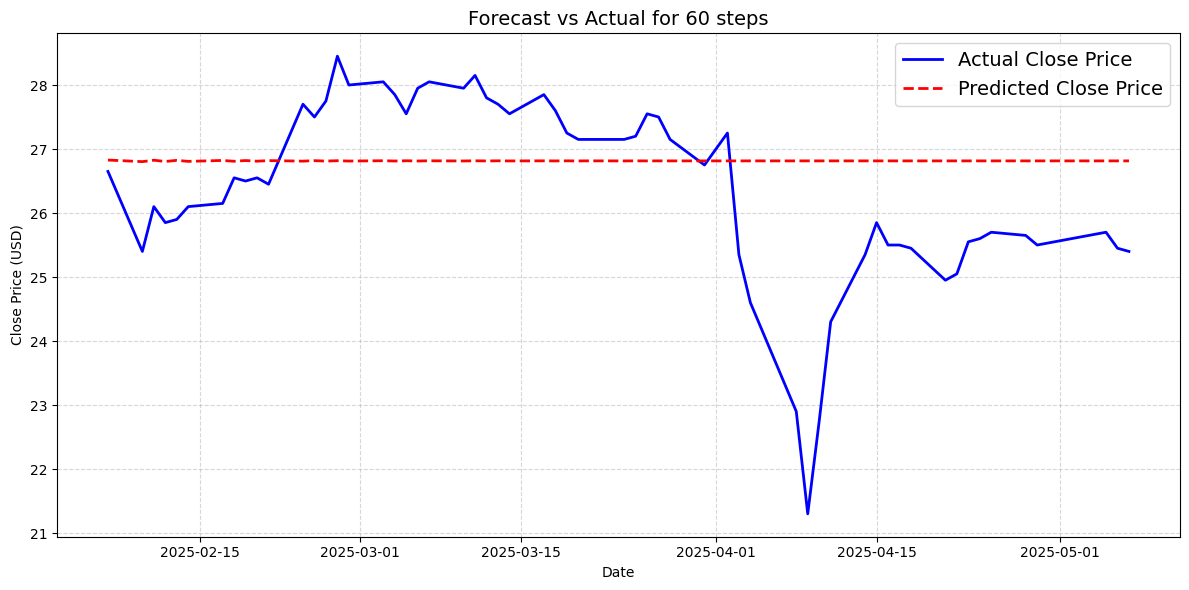

In [27]:
for step in forecast_steps:
    test = forecast_results[step]['test']
    forecast = forecast_results[step]['forecast']
    
    # Đồng bộ chỉ số ngày
    forecast.index = test.index

    plt.figure(figsize=(12, 6))
    
    # Actual close price
    plt.plot(test.index, test, color='blue', linewidth=2, label='Actual Close Price')
    
    # Forecasted close price
    plt.plot(forecast.index, forecast, color='red', linestyle='--', linewidth=2, label='Predicted Close Price')

    # Formatting
    plt.title(f"Forecast vs Actual for {step} steps", fontsize=14)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Close Price (USD)', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()


In [12]:
print("\nForecasted Close Prices:")
print(forecast)


Forecasted Close Prices:
4262    27.018445
4263    27.001801
4264    27.016820
4265    27.003267
4266    27.015497
          ...    
4347    27.009694
4348    27.009697
4349    27.009695
4350    27.009697
4351    27.009695
Name: predicted_mean, Length: 90, dtype: float64
